# Integrating Orbits about an orbiting satellite

This recipe is a minimum working example for integrating orbits in a circularly orbiting but fixed potential.  We compute and compare both the inertial and non-inertial frames.

As in the linear motion case, we:
1. Build the basis and coefficients from scratch
2. Implement a orbiting basis
3. Integrate orbits in the inertial frame

In [1]:
# some preliminaries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import pyEXP
import pyEXP

# check the version
pyEXP.util.getVersionInfo()


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% This is EXP 7.8.2 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% Repository URL | https://github.com/EXP-code/EXP                         %
%%%%% Current branch | pseudoAccel                                             %
%%%%% Current commit | 186ceffc9434dd7d1424e17e7ff16a5f180a25e2                %
%%%%% Compile time   | 2025-04-22 13:34:01 EDT                                 %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



In [3]:
lmax,nmax = 4,10

bconfig = """
---
id: sphereSL
parameters :
  numr: 2000
  rmin: 0.0001
  rmax: 1.95
  Lmax: {}
  nmax: {}
  rmapping: 0.0667
  modelname: SLGridSph.model
  cachename: sphereSL.cache
...
""".format(lmax,nmax)

# Construct the basis instance
#
halo_basis   = pyEXP.basis.Basis.factory(bconfig)

---- SLGridSph::ReadH5Cache: successfully read basis cache <sphereSL.cache>
---- Spherical::orthoTest: worst=0.00016446


In [4]:
# now make a custom array of complex coefficients to install
lnumber = int((lmax+1)*(lmax+2)/2)
halo_coef_matrix = np.zeros([lnumber,nmax], dtype=np.complex128)

# set just the lowest-order term
halo_coef_matrix[0,0]=1.0

## Try an orbiting field

In [5]:
# make dummy coefficients for this basis to test orbits
halo_coef  = halo_basis.createFromArray([1.],[[1.],[1.],[1.]], time=0.0)
halo_coefs = pyEXP.coefs.Coefs.makecoefs(halo_coef, 'halo')

# Orbit at R=3
Ro     = 3.0
Period = 300
Freq   = 2.0*np.pi/Period
Time   = 0.0
dT     = 2.0

# Build a time series for testing the non-inertial logic
ctimes = []
center = []

while Time < 300+0.5*dT:
    Phi = Freq*Time
    coef = halo_coef.deepcopy()
    coef.setCoefTime(Time)
    x = Ro*np.cos(Phi)
    y = Ro*np.sin(Phi)
    coef.setCoefCenter([x, y, 0.])
    ctimes.append(Time)
    center.append([x, y, 0.])
    coef.assign(halo_coef_matrix, lmax, nmax)
    halo_coefs.add(coef)
    Time += dT

###  Now that we have a coefficients that cover [0, 300], we can integrate an orbit

In [6]:
# pick a phase space for some orbit:
ps = [[Ro+0.25,0,0,0,0.5,0.0]]

# set up the model with the basis and coefficients
model = [[halo_basis, halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

start_time,end_time,dt = 0.0,300.0,0.01
# integrate the orbit
times, orbits = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps, model, func)

### Plot the orbit

Text(0, 0.5, 'y')

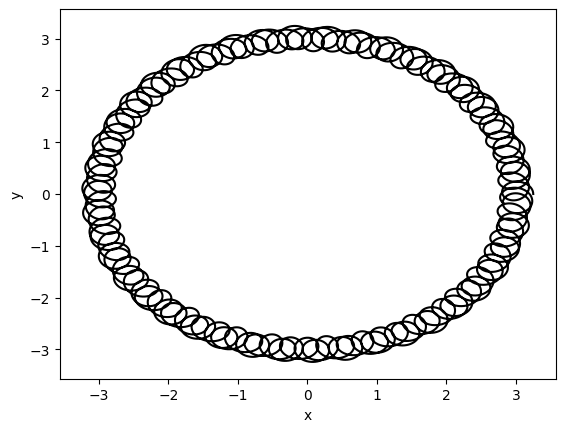

In [7]:
plt.plot(orbits[0][0,:],orbits[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')

## We can now use the same coefficient set to test the orbits in the non-inertial frame

In [8]:
# pick a phase space for some orbit:
ps2 = [[0.25,0,0,0,0.5,0.0]]

# set up the non-internal frame
halo_basis.setNonInertial(10, ctimes, center)

# set up the model with the basis and coefficients
model = [[halo_basis, halo_coefs]]

# set up a basic acceleration integration
func = pyEXP.basis.AllTimeAccel()

start_time,end_time,dt = 0.0,300.0,0.01
# integrate the orbit
times2, orbits2 = pyEXP.basis.IntegrateOrbits(start_time, end_time, dt, ps2, model, func)

### Plot the orbit in the moving frame

Text(0, 0.5, 'y')

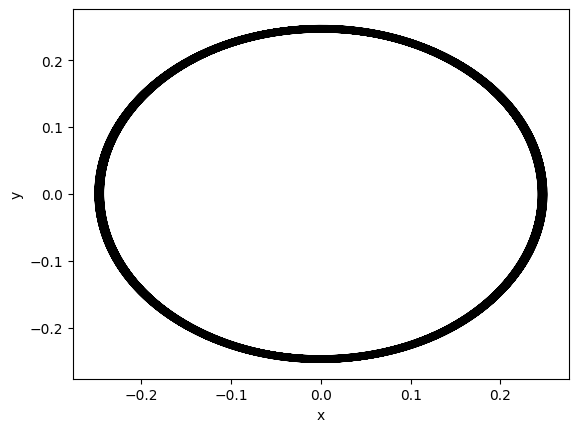

In [9]:
plt.plot(orbits2[0][0,:],orbits2[0][1,:],color='black')
plt.xlabel('x')
plt.ylabel('y')

## Compare with first set of orbits

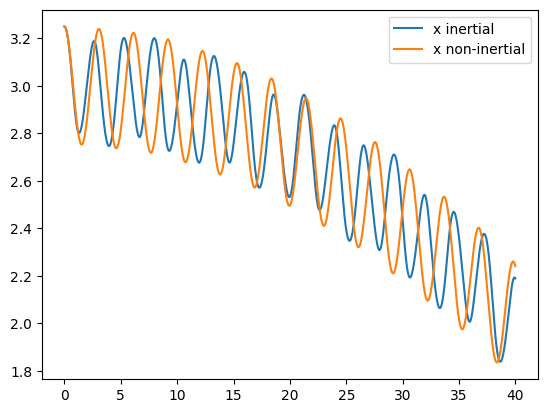

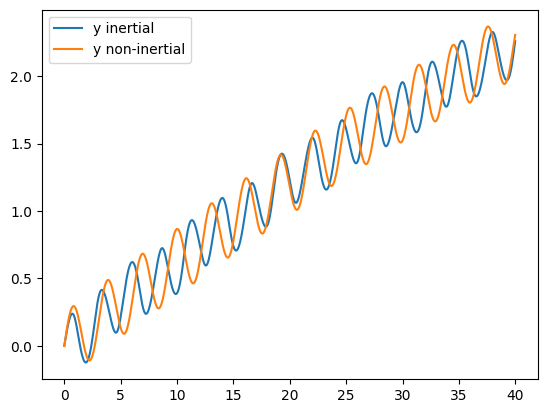

In [10]:
# Final point
last = 4000

plt.plot(times[:last], orbits[0][0, :last], label='x inertial')
plt.plot(times2[:last], orbits2[0][0, :last]+Ro*np.cos(Freq*times2[:last]), label='x non-inertial')
plt.legend()
plt.show()
plt.plot(times[:last], orbits[0][1, :last], label='y inertial')
plt.plot(times2[:last], orbits2[0][1, :last]+Ro*np.sin(Freq*times2[:last]), label='y non-inertial')
plt.legend()
plt.show()